In [1]:
visual_data = data.groupby(['uu_id'])['total_claims'].sum().reset_index().merge(
    data_dict['wage_data'],
    on=['uu_id'],
    how='inner',
)
sns.scatterplot(data=visual_data, x='total_claims', y='average_wage', marker='+')

NameError: name 'data' is not defined

In [2]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [3]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!pip install db-dtypes pmdarima 'google-cloud-bigquery[pandas]' tqdm\n")

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [4]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
from google.cloud import bigquery

In [5]:
from pmdarima.arima import AutoARIMA

In [6]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [7]:
def print_missing(data: pd.DataFrame):
    """Show how much missing data in each column of the input DataFrame."""
    for cname, cvalues in data.items():
        print('Column {} has {} ({}%) missing value(s)'.format(
            cname,
            cvalues.isna().sum(),
            round(100.0 * cvalues.isna().sum() / len(cvalues), 2),
        ))

In [8]:
data_tables = bigquery_client.query(f"""
    SELECT table_catalog, table_schema, table_name
    FROM `ironhacks_competition.INFORMATION_SCHEMA.TABLES`
""").to_dataframe()
print(data_tables)

    table_catalog           table_schema         table_name
0  ironhacks-data  ironhacks_competition          wage_data
1  ironhacks-data  ironhacks_competition    prediction_list
2  ironhacks-data  ironhacks_competition  unemployment_data


In [9]:
# Read all data tables in ironhacks-data.ironhacks_competition
data_dict = {
    table_name: bigquery_client.query(f"""
        SELECT * FROM `ironhacks-data.ironhacks_competition.{table_name}`
    """).to_dataframe()
    for table_name in data_tables['table_name'].tolist()
}

In [10]:
common_cols = list(set(data_dict['unemployment_data'].columns) & set(data_dict['wage_data'].columns))
print(f'Common columns: {common_cols}')
data = data_dict['unemployment_data'].merge(
    data_dict['wage_data'],
    on=common_cols,
    how='left',
).sort_values(['countyfips', 'week_number']).drop_duplicates().reset_index(drop=True)
data['timeperiod'] = pd.to_datetime(data['timeperiod'], format='%Y%m%d')
data

Common columns: ['tract_name', 'countyfips', 'tract', 'uu_id']


,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
0,983badfd7b568728e39a2344a9006078,2022-01-01,1,18001,30200,"Census Tract 302, Adams County, Indiana",16,<NA>,<NA>,<NA>,...,<NA>,0,0,0,0,0,0,<NA>,<NA>,11816.666667
1,983badfd7b568728e39a2344a9006078,2022-01-08,2,18001,30200,"Census Tract 302, Adams County, Indiana",23,<NA>,<NA>,16,...,12,0,0,<NA>,<NA>,0,0,<NA>,18,11816.666667
2,983badfd7b568728e39a2344a9006078,2022-01-15,3,18001,30200,"Census Tract 302, Adams County, Indiana",18,<NA>,<NA>,12,...,<NA>,0,0,<NA>,<NA>,<NA>,0,<NA>,<NA>,11816.666667
3,983badfd7b568728e39a2344a9006078,2022-01-29,5,18001,30200,"Census Tract 302, Adams County, Indiana",20,<NA>,<NA>,<NA>,...,<NA>,0,0,<NA>,0,<NA>,0,<NA>,16,11816.666667
4,983badfd7b568728e39a2344a9006078,2022-02-05,6,18001,30200,"Census Tract 302, Adams County, Indiana",16,0,<NA>,10,...,<NA>,0,0,<NA>,0,<NA>,0,0,<NA>,11816.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,fb55464f8e34af6d750d06968bf719b8,2022-08-06,32,18183,50400,"Census Tract 504, Whitley County, Indiana",14,0,<NA>,<NA>,...,<NA>,0,0,0,0,0,0,<NA>,<NA>,13613.500000
13973,fb55464f8e34af6d750d06968bf719b8,2022-08-13,33,18183,50400,"Census Tract 504, Whitley County, Indiana",21,0,<NA>,16,...,<NA>,0,0,0,0,<NA>,0,<NA>,<NA>,13613.500000
13974,fb55464f8e34af6d750d06968bf719b8,2022-08-20,34,18183,50400,"Census Tract 504, Whitley County, Indiana",11,0,<NA>,<NA>,...,<NA>,0,0,0,0,0,0,<NA>,<NA>,13613.500000
13975,0f3d45341a5b113b813ffb7be7f58bab,2022-09-10,37,18183,50300,"Census Tract 503, Whitley County, Indiana",31,0,<NA>,26,...,<NA>,0,0,0,<NA>,0,0,0,<NA>,13992.250000


In [11]:
print(data.columns)
print_missing(data)

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage'],
      dtype='object')
Column uu_id has 0 (0.0%) missing value(s)
Column timeperiod has 0 (0.0%) missing value(s)
Column week_number has 0 (0.0%) missing value(s)
Column countyfips has 0 (0.0%) missing value(s)
Column tract has 0 (0.0%) missing value(s)
Column tract_name has 0 (0.0%) missing value(s)
Column total_claims has 0 (0.0%) missing value(s)
Column edu_8th_or_less has 2532 (18.12%) missing value(s)
Column edu_grades_9_11 has 9084 (64.99%) missing value(s)
Column edu_hs_grad_equiv has 8895 (63.64%) missin

In [12]:
for cname in ['edu', 'gender', 'race']:
    cols = [c for c in data.columns if c.startswith(cname)]
    data[cols] = data[cols].fillna(0)
    data[f'{cname}_missing'] = data['total_claims'] - data[cols].sum(axis=1)

In [13]:
cols = [c for c in data.columns if c.startswith('top_category_employer')]
data[cols] = data[cols].replace('N/A', None)
# data = pd.get_dummies(data, columns=cols, dummy_na=True)
print_missing(data)

Column uu_id has 0 (0.0%) missing value(s)
Column timeperiod has 0 (0.0%) missing value(s)
Column week_number has 0 (0.0%) missing value(s)
Column countyfips has 0 (0.0%) missing value(s)
Column tract has 0 (0.0%) missing value(s)
Column tract_name has 0 (0.0%) missing value(s)
Column total_claims has 0 (0.0%) missing value(s)
Column edu_8th_or_less has 0 (0.0%) missing value(s)
Column edu_grades_9_11 has 0 (0.0%) missing value(s)
Column edu_hs_grad_equiv has 0 (0.0%) missing value(s)
Column edu_post_hs has 0 (0.0%) missing value(s)
Column edu_unknown has 0 (0.0%) missing value(s)
Column top_category_employer1 has 0 (0.0%) missing value(s)
Column top_category_employer2 has 32 (0.23%) missing value(s)
Column top_category_employer3 has 202 (1.45%) missing value(s)
Column gender_female has 0 (0.0%) missing value(s)
Column gender_male has 0 (0.0%) missing value(s)
Column gender_na has 0 (0.0%) missing value(s)
Column race_amerindian has 0 (0.0%) missing value(s)
Column race_asian has 0 (0.

<AxesSubplot: xlabel='total_claims', ylabel='average_wage'>

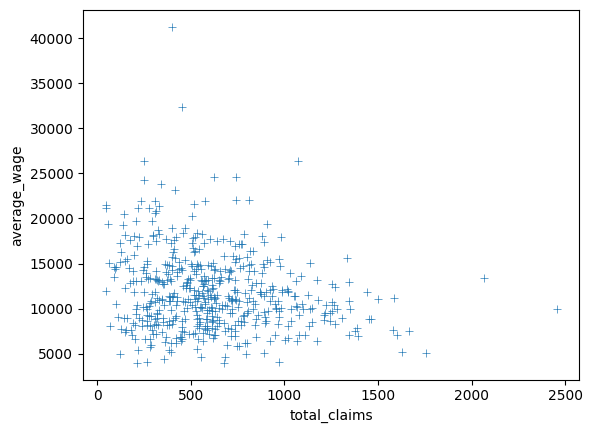

In [14]:
visual_data = data.groupby(['uu_id'])['total_claims'].sum().reset_index().merge(
    data_dict['wage_data'],
    on=['uu_id'],
    how='inner',
)
sns.scatterplot(data=visual_data, x='total_claims', y='average_wage', marker='+')

<AxesSubplot: xlabel='timeperiod'>

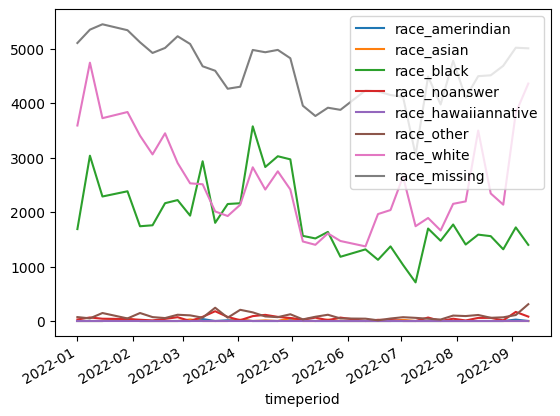

In [15]:
cols_race = [c for c in data.columns if c.startswith('race')]
data.groupby(['timeperiod'])[cols_race].sum().plot(legend=True)

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [16]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

In [17]:
from pmdarima.arima import AutoARIMA

In [18]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

<Figure size 640x480 with 0 Axes>

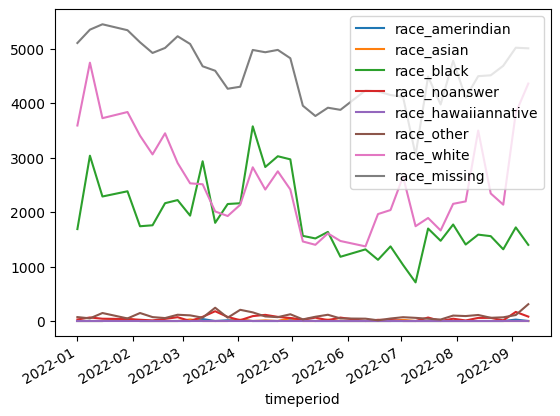

<Figure size 640x480 with 0 Axes>

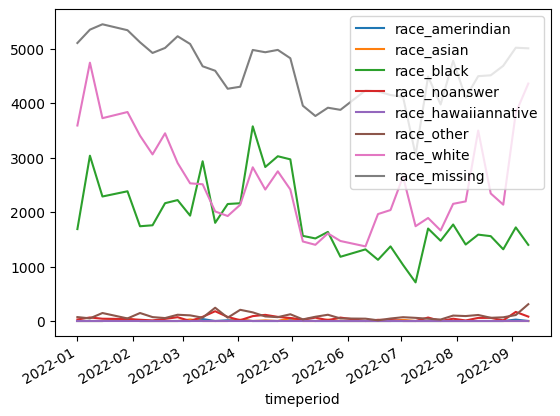

<Figure size 640x480 with 0 Axes>

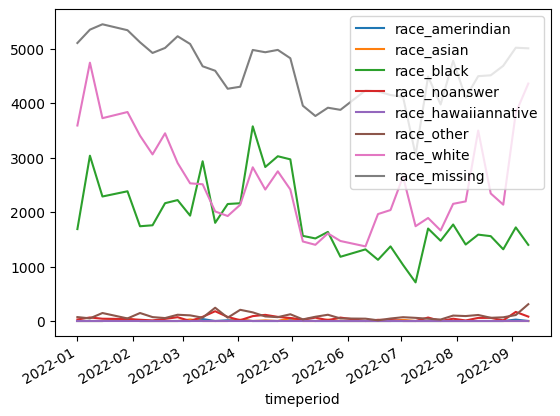

In [19]:
for cname in ['edu', 'gender', 'race']:
    plt.figure()
    cols = [c for c in data.columns if c.startswith(cname)]
    data.groupby(['timeperiod'])[cols_race].sum().plot(legend=True)

<Figure size 640x480 with 0 Axes>

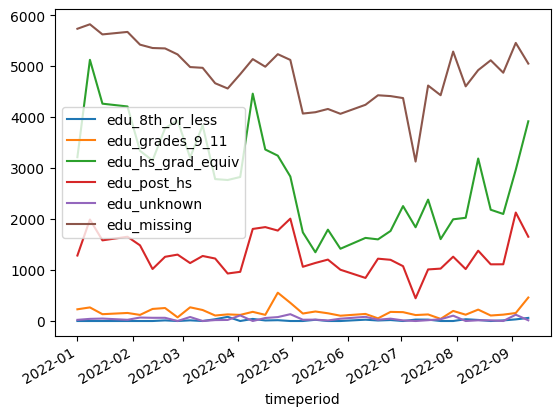

<Figure size 640x480 with 0 Axes>

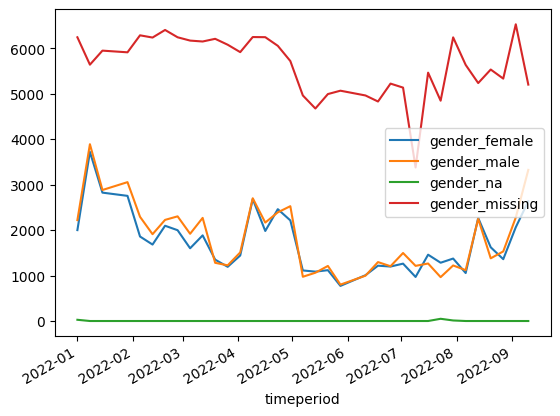

<Figure size 640x480 with 0 Axes>

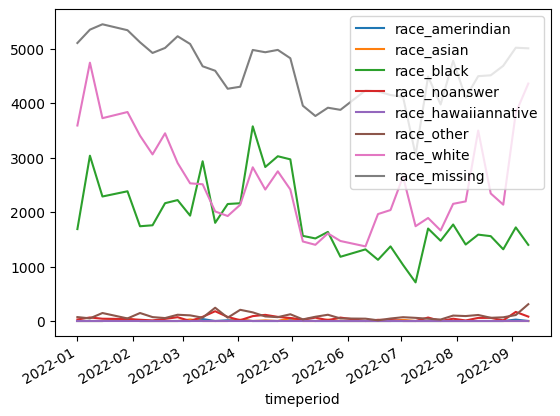

In [20]:
for cname in ['edu', 'gender', 'race']:
    plt.figure()
    cols = [c for c in data.columns if c.startswith(cname)]
    data.groupby(['timeperiod'])[cols].sum().plot(legend=True)

In [21]:
# For our own convenience, create a correspondance DataFrame for `week_number` and `timeperiod`.
wt = pd.Series(
    range(1, 53),
    name='week_number',
    index=pd.date_range('2022-01-01', periods=52, freq='W-SAT').rename('timeperiod'),
).reset_index()
wt['timeperiod'] = wt['timeperiod'].astype(str)
wt.head()

,timeperiod,week_number
0,2022-01-01,1
1,2022-01-08,2
2,2022-01-15,3
3,2022-01-22,4
4,2022-01-29,5
